# Sampling from the Anisotropic Laplace Distribution with Bregman Proximal Langevin Monte Carlo via The Bregman--Moreau Envelopes

In this notebook, we perform sampling from the anisotropic Laplace distribution, using the left Bregman--Moreau unadjusted Langevin algorithms (LBMULA). 

## Import libraries

In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import lambertw

## Hypentropy mirror map
$$
\varphi(\boldsymbol{\theta}) = \sum_{i=1}^d \left[ \theta_i \operatorname{arsinh}\left( \frac{\theta_i}{\beta_i} \right) - \sqrt{\theta_i^2 + \beta_i^2}\right]
$$

In [2]:
def mirror_hyp(theta, beta) -> float: 
    return theta.dot(np.arcsinh(theta / beta)) - np.sum(np.sqrt(theta**2 + beta**2))

$$
\nabla \varphi(\boldsymbol{\theta}) = \left( \operatorname{arsinh}(\theta_i/\beta_i) \right)_{1 \leqslant i \leqslant d}
$$

In [3]:
def grad_mirror_hyp(theta, beta) -> np.ndarray: 
    return np.arcsinh(theta / beta)

$$
\nabla\varphi^*(\boldsymbol{\theta}) = \left( \beta_i\sinh(\theta_i) \right)_{i\leqslant i \leqslant d}
$$

In [4]:
def grad_conjugate_mirror_hyp(theta, beta) -> np.ndarray:
    return beta * np.sinh(theta)

### Function for plots

In [5]:
def plotting(theta, alpha, num_bins=750):
    df = pd.DataFrame(data=theta).to_numpy()

    # the histogram of the data
    # i = 1
    n, bins, patches = plt.hist(df[:,0], num_bins, density=True)
    plt.xlim([-5, 5])
    plt.ylim([0, 0.6])
    x = np.arange(-5., 5., .01)
    pdf = alpha[0] * np.exp(-alpha[0] * abs(x))/2.
    plt.plot(x, pdf)
    plt.title('1st dimension')
    plt.show()

    # i = 2
    n, bins, patches = plt.hist(df[:,1], num_bins, density=True)
    plt.xlim([-3, 3])
    plt.ylim([0, 1.2])
    x = np.arange(-3., 3., .01)
    pdf = alpha[1] * np.exp(-alpha[1] * abs(x))/2.
    plt.plot(x, pdf)
    plt.title('2nd dimension')
    plt.show()

    # i = 5
    n, bins, patches = plt.hist(df[:,4], num_bins, density=True)
    plt.xlim([-1, 1])
    plt.ylim([0, 2.8])
    x = np.arange(-1., 1., .01)
    pdf = alpha[4] * np.exp(-alpha[4] * abs(x))/2.
    plt.plot(x, pdf)
    plt.title('5th dimension')
    plt.show()

    # i = 10
    n, bins, patches = plt.hist(df[:,9], num_bins, density=True)
    plt.xlim([-.75, .75])
    plt.ylim([0, 5.2])
    x = np.arange(-.75, .75, .01)
    pdf = alpha[9] * np.exp(-alpha[9] * abs(x))/2.
    plt.plot(x, pdf)
    plt.title('10th dimension')
    plt.show()

    # i = 25
    n, bins, patches = plt.hist(df[:,24], num_bins, density=True)
    plt.xlim([-.3, .3])
    plt.ylim([0, 13.5])
    x = np.arange(-.3, .3, .005)
    pdf = alpha[24] * np.exp(-alpha[24] * abs(x))/2.
    plt.plot(x, pdf)
    plt.title('25th dimension')
    plt.show()

    # i = 50
    n, bins, patches = plt.hist(df[:,49], num_bins, density=True)
    plt.xlim([-.15, .15])
    plt.ylim([0, 27.5])
    x = np.arange(-.15, .15, .0025)
    pdf = alpha[49] * np.exp(-alpha[49] * abs(x))/2.
    plt.plot(x, pdf)
    plt.title('50th dimension')
    plt.show()

    # i = 75
    n, bins, patches = plt.hist(df[:,74], num_bins, density=True)
    plt.xlim([-.1, .1])
    plt.ylim([0, 39.5])
    x = np.arange(-.1, .1, .00125)
    pdf = alpha[74] * np.exp(-alpha[74] * abs(x))/2.
    plt.plot(x, pdf)
    plt.title('75th dimension')
    plt.show()

    # i = 100
    n, bins, patches = plt.hist(df[:,99], num_bins, density=True)
    plt.xlim([-.075, .075])
    plt.ylim([0, 55])
    x = np.arange(-.075, .075, .001)
    pdf = alpha[99] * np.exp(-alpha[99] * abs(x))/2.
    plt.plot(x, pdf)
    plt.title('100th dimension')
    plt.show()

### Specifications of the potential

In [6]:
d = 100
n = 100000

alpha = np.arange(1, d+1)
beta = np.arange(d+1)[d+1:0:-1]
sigma = np.arange(d+1)[d+1:0:-1]

## Comparison of MYULA, LBMULA and LBMUMLA
In this section, we want to demonstrate that while imposing a mirror map in the Langevin dynamics (i.e., mirror-Langevin dynamics) can address the issue of ill-conditioning (actually this mainly accounts for ill-conditioning in the smooth part of the potential), using a well-chosen mirror map in the Bregman--Moreau envelope can address the issue of ill-conditioning in the nonsmooth part. 

Therefore, we choose $$\psi = \frac{1}{2}\lVert \cdot\rVert^2_{\boldsymbol{M}} = \frac{1}{2}\langle\cdot, \boldsymbol{M} \cdot\rangle,$$ where $\boldsymbol{M} = \mathrm{Diag}(\boldsymbol{m})$ and $\boldsymbol{m} = (m_1, \ldots, m_d)^\top\in\mathbb{R}^d$ and $m_i>0$ for all $i \in\lbrace 1,\ldots,d\rbrace$, while using $\varphi = \frac{1}{2}\lVert \cdot\rVert^2$ which corresponds to a vanilla Langevin dynamics and an unadjusted Langevin algorithm. 

Note that in this case, the left Bregman proximity operator of $\sum_{i=1}^d \alpha_i |\theta_i|$ associated with $\frac{1}{2}\lVert \cdot\rVert^2_{\boldsymbol{M}}$ at ${\boldsymbol{\theta}}$ is 
$$ \operatorname{argmin}_{\boldsymbol{\vartheta}\in\mathbb{R}^d} \ \left\{ \sum_{i=1}^d \left[\alpha_i |\vartheta_i| + \frac{m_i}{2\lambda}(\vartheta_i - \theta_i)^2 \right] \right\} = \operatorname{argmin}_{\boldsymbol{\vartheta}\in\mathbb{R}^d} \ \left\{ \sum_{i=1}^d \left[ |\vartheta_i| + \frac{1}{2\lambda\alpha_i/m_i}(\vartheta_i - \theta_i)^2 \right] \right\}$$

Since this is separable, it is not hard to see that each of its components is equivalent to the (Moreau) proximity operator of $\frac{\lambda\alpha_i}{m_i}|\cdot|$, i.e., 
$$ \overleftarrow{\operatorname{P}}_{\lambda, \|\boldsymbol{\alpha}\odot\cdot\|_1}^{\frac{1}{2}\lVert \cdot\rVert^2_{\boldsymbol{M}}}(\boldsymbol{\theta}) = \left(\operatorname{prox}_{\frac{\lambda\alpha_i}{m_i}|\cdot|}(\theta_i) \right)_{1\leqslant i \leqslant d}. $$

### Function to compute the proximity operator of $\lambda|\cdot|$, where $\lambda > 0$

$$
\operatorname{prox}_{\lambda|\cdot|}(\theta) = \operatorname{sign}(\theta)\max\{0, |\theta| - \lambda\}
$$

In [7]:
def prox_abs(theta, lam) -> np.ndarray:
    return np.sign(theta) * np.maximum(np.abs(theta) - lam, 0)

In [8]:
def left_bregman_prox_ell_one_hypent(theta, beta, gamma) -> np.ndarray:
    if isinstance(theta, float):
        if theta > beta * np.sinh(gamma):
            prox = beta * np.sinh(np.arcsinh(theta / beta) - gamma)
        elif theta < beta * np.sinh(-gamma):
            prox = beta * np.sinh(np.arcsinh(theta / beta) + gamma)
        else: 
            prox = np.sqrt(theta ** 2 + beta ** 2) - beta
    else:
        prox = np.array(len(theta))
        p1 = beta * np.sinh(np.arcsinh(theta / beta) - gamma)
        p2 = beta * np.sinh(np.arcsinh(theta / beta) + gamma)
        p3 = np.sqrt(theta ** 2 + beta ** 2) - beta
        prox = np.where(theta > beta * np.sinh(gamma), p1, p3)
        prox = np.where(theta < beta * np.sinh(-gamma), p2, prox)
    return prox

### Function for the MYULA main loop

In [9]:
def myula(gamma, lam, alpha, d=100, n=100000):
    np.random.seed(0)
    theta0 = np.random.normal(0, 1, d)
    theta = []

    for i in range(n):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = theta0 - gamma/lam * (theta0 - prox_abs(theta0, lam * alpha)) + np.sqrt(2*gamma) * xi
        theta.append(theta_new)    
        theta0 = theta_new

    return theta

### The MYULA main loop with $\gamma = 0.000005$

In [10]:
theta1 = myula(5e-6, 1e-5, alpha, d, n)

### Density and histogram plots of the samples generated by MYULA  ($\gamma = 0.000005$)

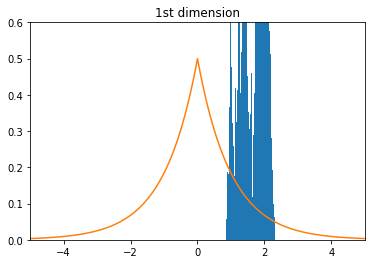

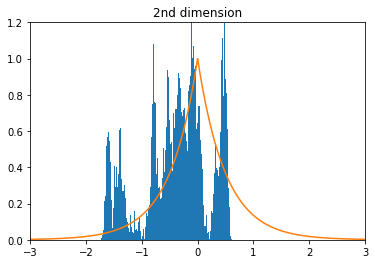

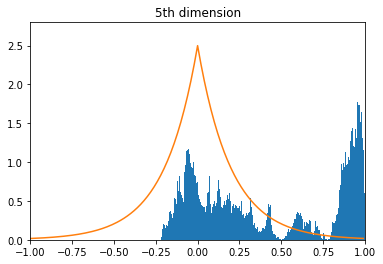

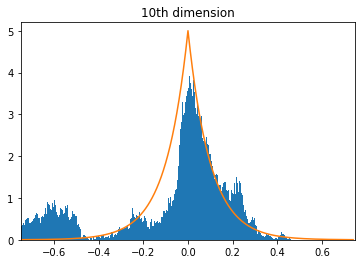

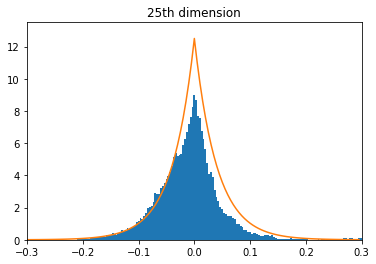

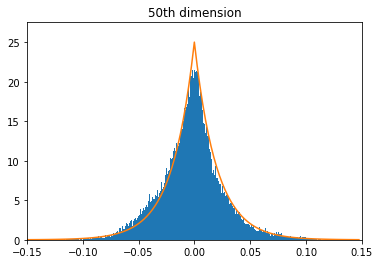

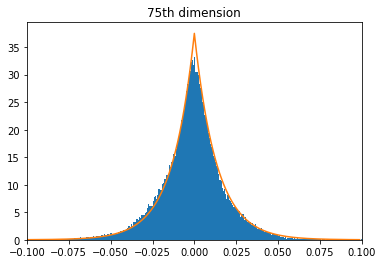

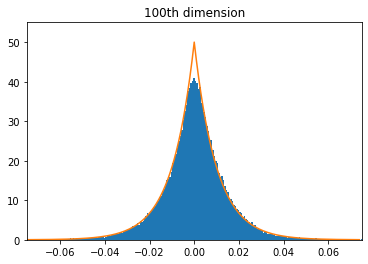

In [11]:
plotting(theta1, alpha)

### Function for the LBMULA main loop, where $\psi = \frac{1}{2}\lVert \cdot\rVert^2_{\boldsymbol{M}} = \frac{1}{2}\langle\cdot, \boldsymbol{M} \cdot\rangle$, where $\boldsymbol{M} = \mathrm{Diag}(\boldsymbol{m}) $

In [12]:
def lbmula(gamma, lam, alpha, m, d=100, n=100000):
    np.random.seed(0)
    theta0 = np.random.normal(0, 1, d)
    theta = []

    for i in range(n):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = theta0 - gamma * m/lam * (theta0 - prox_abs(theta0, lam * alpha / m)) + np.sqrt(2*gamma) * xi
        theta.append(theta_new)    
        theta0 = theta_new

    return theta

### Function to compute $\overleftarrow{\operatorname{P}}_{\negthinspace\negthinspace \lambda, g}^\psi$ when $g = \| \cdot\|_1$ and $\psi(\boldsymbol{\theta}) = (\exp(\theta_i))_{1 \leqslant i \leqslant d}$

$$
\overleftarrow{\operatorname{P}}_{\negthinspace\negthinspace \lambda, g}^\psi(\boldsymbol{\theta}) = \operatorname{argmin}_{\boldsymbol{\vartheta}\in\mathbb{R}^d} \left\{\|\boldsymbol{\vartheta}\|_1 + \frac1\lambda D_\psi(\boldsymbol{\vartheta}, \boldsymbol{\theta})  \right\}
$$ 

In [13]:
def left_bregman_prox_ell_one_exp(theta, lam) -> np.ndarray:
    if isinstance(theta, float):
        if theta > np.log(1 + lam):
            prox = np.log(np.exp(theta) - lam)
        elif theta < np.log(1 - lam):
            prox = np.log(np.exp(theta) + lam)
        else: 
            prox = 1 - np.exp(theta) * (1 + theta)
    else:
        prox = np.array(len(theta))
        p1 = np.log(np.exp(theta) - lam)
        p2 = np.log(np.exp(theta) + lam)
        p3 = 1 - np.exp(theta) * (1 + theta)
        prox = np.where(theta > np.log(1 + lam), p1, p3)
        prox = np.where(theta < np.log(1 - lam), p2, prox)
    return prox

### Function for LBMUMLA main loop with the hypentropy mirror map and the exponential mirror map for the left Bregman--Moreau envelope

In [14]:
def lbmumla_hyp_exp(gamma, lam, alpha, beta, d=100, n=100000):
    np.random.seed(0)
    theta0 = np.random.normal(0, 1, d)
    theta = []

    for i in range(n):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = grad_mirror_hyp(theta0, beta) - gamma/lam * np.exp(theta0) * (theta0 - left_bregman_prox_ell_one_exp(theta0, lam * alpha)) + np.sqrt(2*gamma) * (theta0**2 + beta**2)**(-.25) * xi
        theta_new = grad_conjugate_mirror_hyp(theta_new, beta)
        theta.append(theta_new)    
        theta0 = theta_new

    return theta

### Function for LBMUMLA main loop with the hypentropy mirror map and $\psi = \frac{1}{2}\lVert \cdot\rVert^2_{\boldsymbol{M}}$ for the left Bregman--Moreau envelope

In [15]:
def lbmumla_hyp_M(gamma, lam, alpha, beta, m, d=100, n=100000):
    np.random.seed(0)
    theta0 = np.random.normal(0, 1, d)
    theta = []

    for i in range(n):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = grad_mirror_hyp(theta0, beta) - gamma/lam * m * (theta0 - prox_abs(theta0, lam * alpha / m)) + np.sqrt(2*gamma) * (theta0**2 + beta**2)**(-.25) * xi
        theta_new = grad_conjugate_mirror_hyp(theta_new, beta)
        theta.append(theta_new)    
        theta0 = theta_new

    return theta

### Function for LBMUMLA main loop with the hypentropy mirror map and $\psi_{\boldsymbol{\sigma}} = $ hypentropy for the left Bregman--Moreau envelope

In [16]:
def lbmumla_hyp_hyp(gamma, lam, alpha, beta, sigma, d=100, n=100000):
    np.random.seed(0)
    theta0 = np.random.normal(0, 1, d)
    theta = []

    for i in range(n):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = grad_mirror_hyp(theta0, beta) - gamma/lam * (theta0**2 + sigma**2)**(-.5) * (theta0 - left_bregman_prox_ell_one_hypent(theta0, sigma, lam * alpha)) + np.sqrt(2*gamma) * (theta0**2 + beta**2)**(-.25) * xi
        theta_new = grad_conjugate_mirror_hyp(theta_new, beta)
        theta.append(theta_new)    
        theta0 = theta_new
        # if i % 10000 == 0:
            # gamma *= .99

    return theta

In [17]:
def lbmumla_hyp_hyp_dec(gamma, lam, alpha, beta, sigma, d=100, n=100000):
    np.random.seed(0)
    theta0 = np.random.normal(0, 1, d)
    theta = []

    for i in range(n):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = grad_mirror_hyp(theta0, beta) - gamma/lam * (theta0**2 + sigma**2)**(-.5) * (theta0 - left_bregman_prox_ell_one_hypent(theta0, sigma, lam * alpha)) + np.sqrt(2*gamma) * (theta0**2 + beta**2)**(-.25) * xi
        theta_new = grad_conjugate_mirror_hyp(theta_new, beta)
        theta.append(theta_new)    
        theta0 = theta_new
        if i % 1000 == 0:
            gamma *= .99

    return theta

### The LBMUMLA main loop with $\lambda=0.00001$ and $\gamma = 0.000005$ using exponential function in BME

In [18]:
theta2 = lbmumla_hyp_exp(5e-6, 1e-5, alpha, beta, d, n)

### Density and histogram plots of the samples generated by LBMUMLA ($\gamma=0.000005$) using exponential function in BME

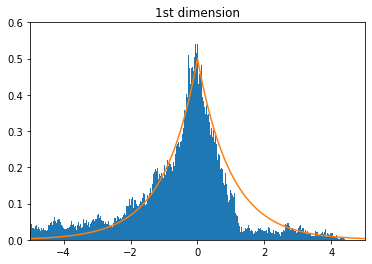

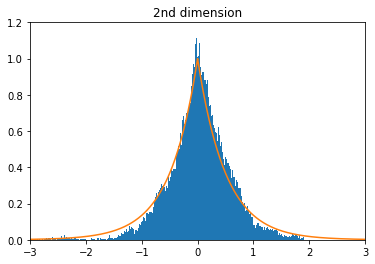

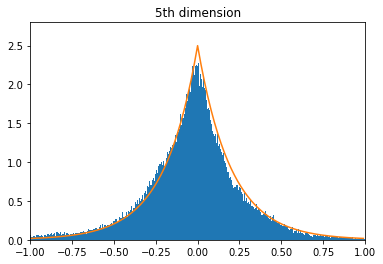

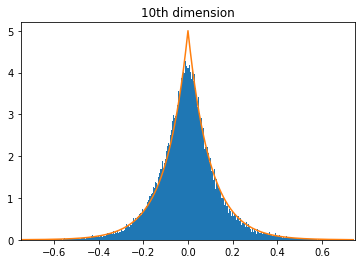

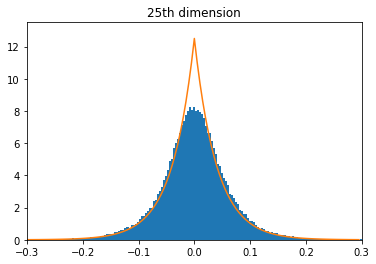

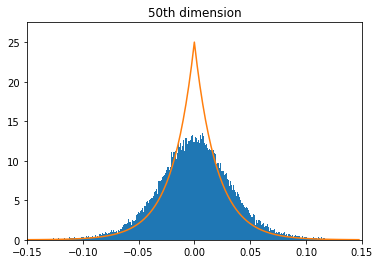

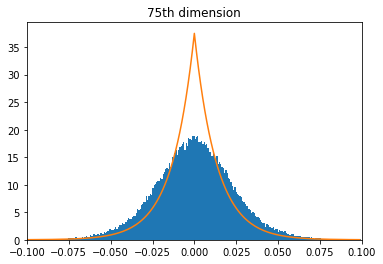

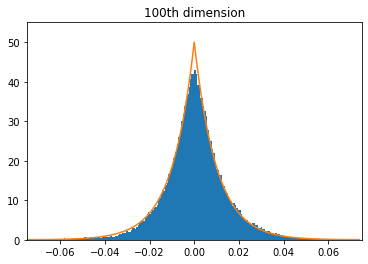

In [19]:
plotting(theta2, alpha)

In [20]:
theta3 = lbmumla_hyp_hyp(5e-6, 1e-5, alpha, 2 * beta**(.5), sigma, d, n)

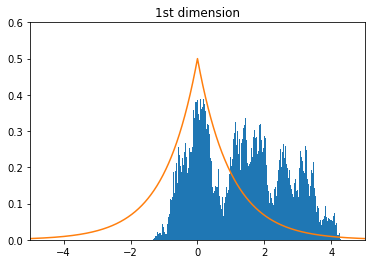

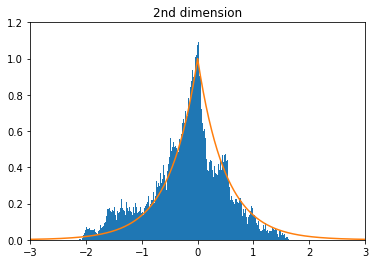

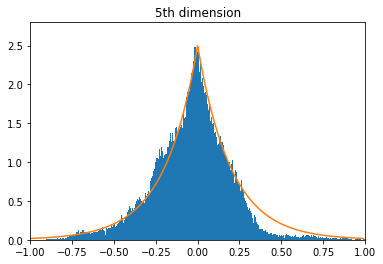

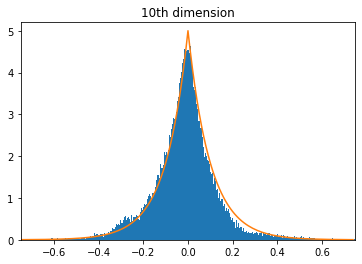

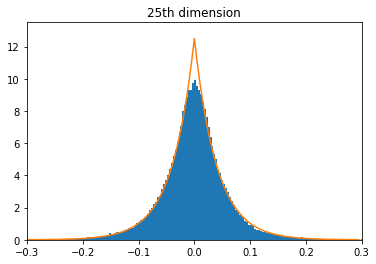

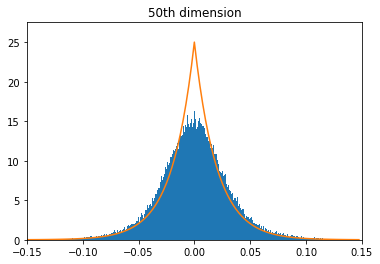

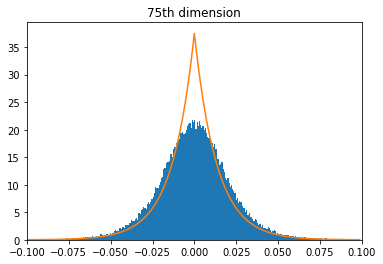

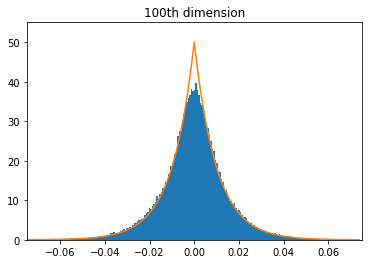

In [21]:
plotting(theta3, alpha)

In [22]:
theta4 = lbmumla_hyp_hyp_dec(5e-6, 1e-5, alpha, 5 * beta**(.5), sigma, d, n)

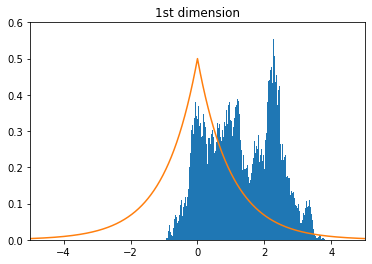

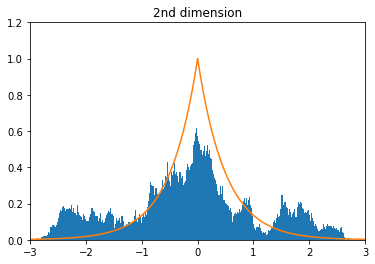

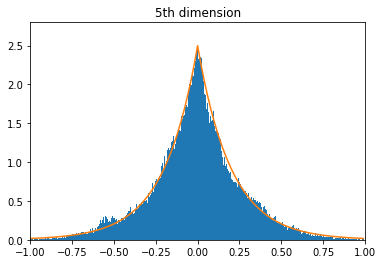

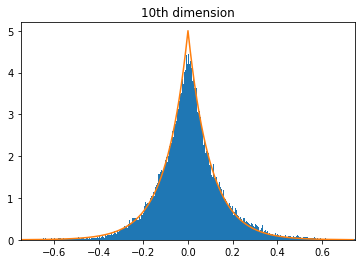

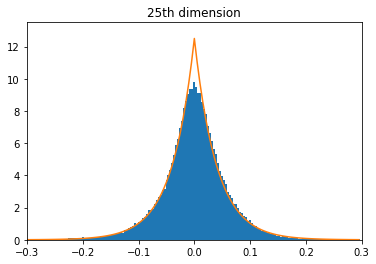

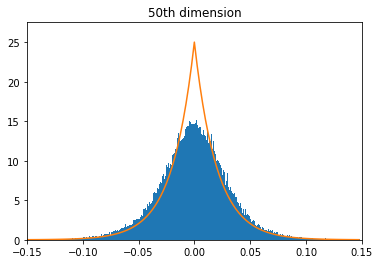

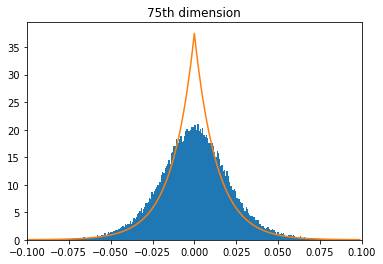

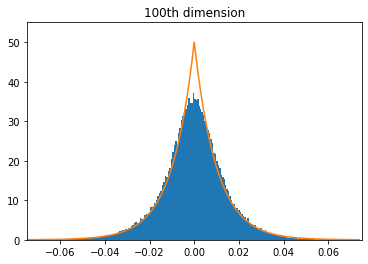

In [23]:
plotting(theta4, alpha)

In [24]:
theta6 = lbmumla_hyp_M(5e-6, 1e-5, alpha, 2*beta**(.5), alpha/2, d, n)

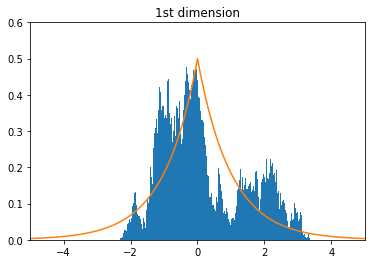

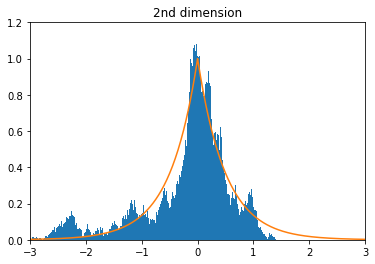

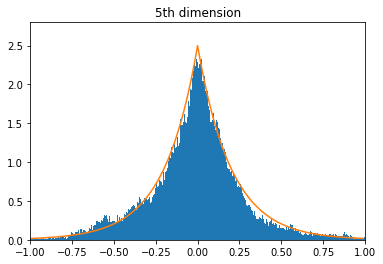

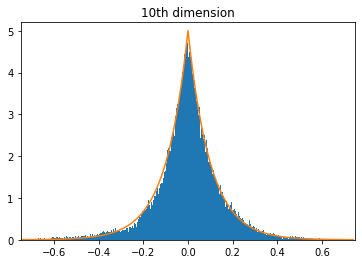

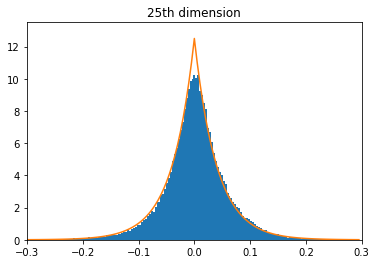

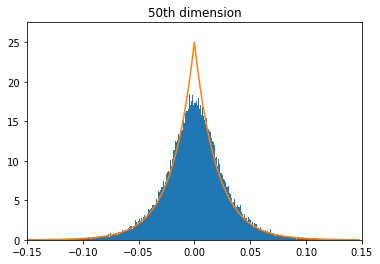

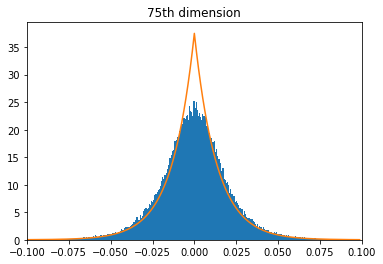

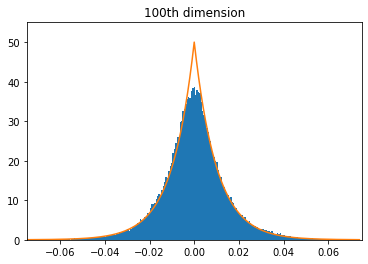

In [25]:
plotting(theta6, alpha)

In [26]:
def plotting_save(theta, alpha, alg, num_bins=750):
    df = pd.DataFrame(data=theta).to_numpy()

    # the histogram of the data
    # i = 1
    plt.figure(0)
    plt.style.use(['science', 'light'])
    n, bins, patches = plt.hist(df[:,0], num_bins, density=True)
    plt.xlim([-5, 5])
    plt.ylim([0, 0.6])
    x = np.arange(-5., 5., .01)
    pdf = alpha[0] * np.exp(-alpha[0] * abs(x))/2.
    plt.plot(x, pdf)
    # plt.title('1st dimension')
    # plt.show()
    plt.savefig(f'../fig/an_laplace_{alg}_1.pdf', dpi=500)  

    # i = 2
    plt.figure(1)
    plt.style.use(['science', 'light'])
    n, bins, patches = plt.hist(df[:,1], num_bins, density=True)
    plt.xlim([-3, 3])
    plt.ylim([0, 1.2])
    x = np.arange(-3., 3., .01)
    pdf = alpha[1] * np.exp(-alpha[1] * abs(x))/2.
    plt.plot(x, pdf)
    # plt.title('2nd dimension')
    # plt.show()
    plt.savefig(f'../fig/an_laplace_{alg}_2.pdf', dpi=500)

    # i = 5
    plt.figure(2)
    n, bins, patches = plt.hist(df[:,4], num_bins, density=True)
    plt.xlim([-1, 1])
    plt.ylim([0, 2.8])
    x = np.arange(-1., 1., .01)
    pdf = alpha[4] * np.exp(-alpha[4] * abs(x))/2.
    plt.plot(x, pdf)
    # plt.title('5th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_laplace_{alg}_5.pdf', dpi=500)  

    # i = 10
    plt.figure(3)
    n, bins, patches = plt.hist(df[:,9], num_bins, density=True)
    plt.xlim([-.75, .75])
    plt.ylim([0, 5.2])
    x = np.arange(-.75, .75, .01)
    pdf = alpha[9] * np.exp(-alpha[9] * abs(x))/2.
    plt.plot(x, pdf)
    # plt.title('10th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_laplace_{alg}_10.pdf', dpi=500)  

    # i = 25
    plt.figure(4)
    n, bins, patches = plt.hist(df[:,24], num_bins, density=True)
    plt.xlim([-.3, .3])
    plt.ylim([0, 13.5])
    x = np.arange(-.3, .3, .005)
    pdf = alpha[24] * np.exp(-alpha[24] * abs(x))/2.
    plt.plot(x, pdf)
    # plt.title('25th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_laplace_{alg}_25.pdf', dpi=500)  

    # i = 50
    plt.figure(5)
    n, bins, patches = plt.hist(df[:,49], num_bins, density=True)
    plt.xlim([-.15, .15])
    plt.ylim([0, 27.5])
    x = np.arange(-.15, .15, .0025)
    pdf = alpha[49] * np.exp(-alpha[49] * abs(x))/2.
    plt.plot(x, pdf)
    # plt.title('50th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_laplace_{alg}_50.pdf', dpi=500)  

    # i = 75
    plt.figure(6)
    n, bins, patches = plt.hist(df[:,74], num_bins, density=True)
    plt.xlim([-.1, .1])
    plt.ylim([0, 39.5])
    x = np.arange(-.1, .1, .00125)
    pdf = alpha[74] * np.exp(-alpha[74] * abs(x))/2.
    plt.plot(x, pdf)
    # plt.title('75th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_laplace_{alg}_75.pdf', dpi=500)  

    # i = 100
    plt.figure(7)
    n, bins, patches = plt.hist(df[:,99], num_bins, density=True)
    plt.xlim([-.075, .075])
    plt.ylim([0, 55])
    x = np.arange(-.075, .075, .001)
    pdf = alpha[99] * np.exp(-alpha[99] * abs(x))/2.
    plt.plot(x, pdf)
    # plt.title('100th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_laplace_{alg}_100.pdf', dpi=500)  

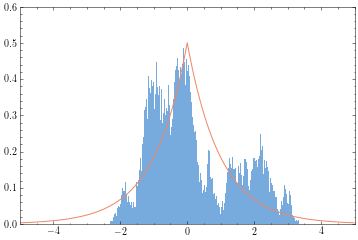

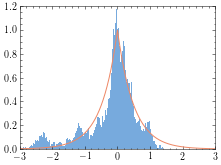

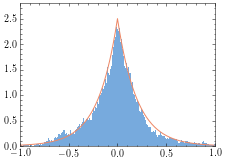

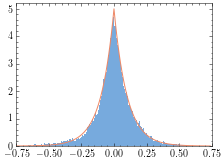

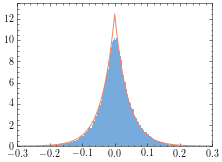

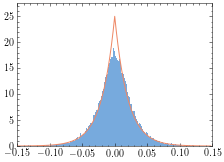

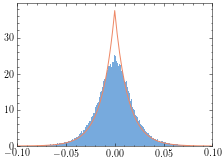

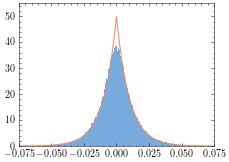

In [27]:
plotting_save(theta6, alpha, "bmumla")

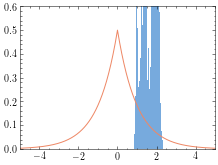

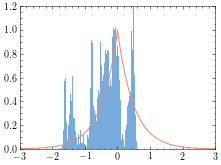

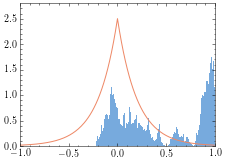

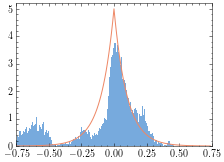

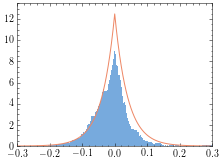

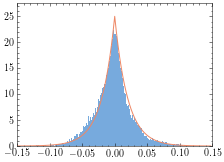

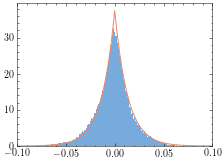

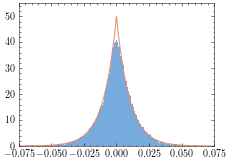

In [28]:
plotting_save(theta1, alpha, "myula")

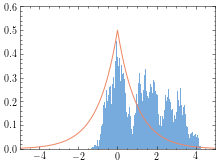

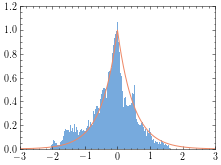

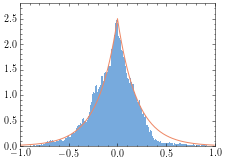

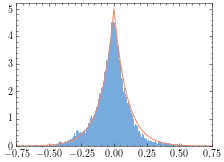

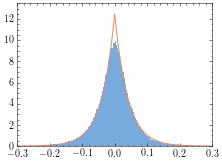

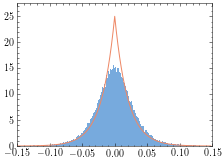

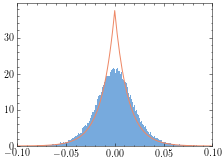

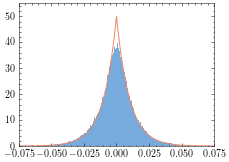

In [29]:
plotting_save(theta3, alpha, "bmumla_hyp")